In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("../clean_news_paragraphs.json")
dti = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
df["time"] = dti
print(df["paragraph"].iloc[1])
print(df["filename"].iloc[0])
df

ValueError: Expected object or value

## Data Statistics

### Statistics of number of paragraphs per news report

In [2]:
# Number of paragraphs per news report
frequencies_df = df["time"].value_counts()
print(frequencies_df)

# drop files with 1 detected paragraph - error
# Average number of paragraph per news report
df["time"].value_counts().mean()

2019-06-20 08:00:00    10
2020-02-09 08:00:00    10
2020-04-01 08:00:00    10
2019-12-18 08:00:00    10
2020-02-05 08:00:00    10
                       ..
2019-03-20 21:00:00     3
2019-09-17 08:00:00     2
2019-08-08 08:00:00     2
2019-11-21 21:00:00     2
2020-01-28 21:00:00     2
Name: time, Length: 881, dtype: int64


5.82633371169126

### One Sample

In [3]:
aa=df.iloc[1,0]
print(aa)

שלושה ימים לפתיחת שנת הלימודים
 אלפי מורים סיימו בשעה זו להפגין ברחבת מוזיאון תל אביב כחלק ממחאת הסתדרות המורים על תנאי העסקתם
 ההפגנה נערכת על רקע המגעים בין ההסתדרות למשרד האוצר על פתיחת שנת הלימודים בבתי הספר היסודיים כסדרה ומטרתה היא להשפיע על משרדי הממשלה להיענות לדרישותיהם של עובדי ההוראה

מזכלית הסתדרות המורים יפה בן דוד אמרה בהפגנה כי היום אני עומדת כאן כדי לאותת למדינת ישראל
 עובדי הוראה יפסיקו לשתוק ודורשים את הזכויות שמגיעות להם על פי החוק״

 כתבנו לענייני חינוך דורון קדוש מזכיר כי מועד סיום המשא ומתן הוא מחר ב9 בבוקר אז יצטרכו הצדדים לדווח על ההתפתחויות לבית הדין   שיכריע סופית  בדבר השביתה



### Stopwords analysis

In [4]:
def get_hebrew_stopwords(top_k):
    stop_path="../added_material/heb_stopwords.txt"
    with open(stop_path, encoding="utf-8") as in_file:
        lines=in_file.readlines()
        res=[l.strip() for l in lines]
        print(res[:top_k])
    return res

stop = set(get_hebrew_stopwords(10))
paragraph_text = df["paragraph"]

['את', 'לא', 'של', 'אני', 'על', 'זה', 'עם', 'כל', 'הוא', 'אם']


##### Character Length Histogram

In [5]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist()

Character Length Histogram


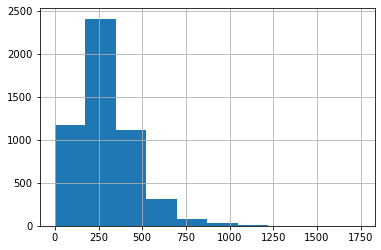

In [6]:
print("Character Length Histogram")
plot_character_length_histogram(paragraph_text)

###### Word Number Histogram

In [7]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    
def average_word_number(text):
    return text.str.split().apply(len).\
        mean()

mean:49.99279875437914


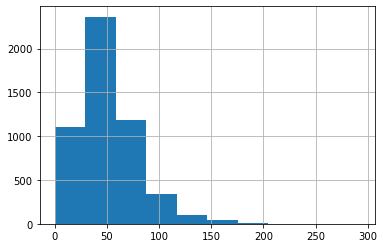

In [8]:
plot_word_number_histogram(paragraph_text)
print("mean:" + str(average_word_number(paragraph_text)))

##### Top Stopwords Barchart

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_stopwords_barchart(text, stop):
    #stop=set(stopwords.words('english'))
    #stop=set(get_hebrew_stopwords())
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    x=[w[::-1] for w in x]
    plt.bar(x,y)

In [10]:
def invert_words(words):
    return [w[::-1] for w in words]

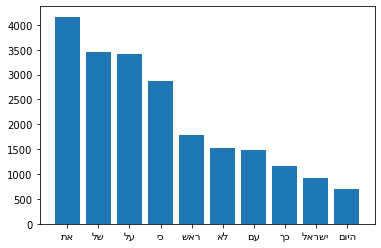

In [11]:
plot_top_stopwords_barchart(paragraph_text, stop)

#### Top Non-Stopwords Barchart

In [12]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text, stop):
    #stop=set(get_hebrew_stopwords())
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)            
    sns.barplot(x=y,y=invert_words(x))

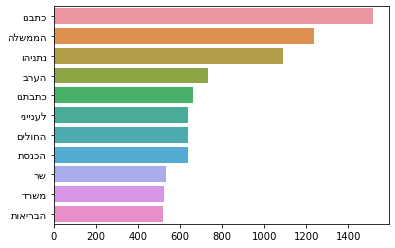

In [13]:
plot_top_non_stopwords_barchart(paragraph_text, stop)

###### Stopwords in Evening Only:

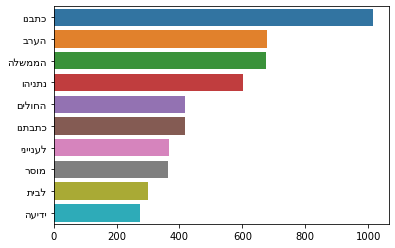

In [14]:
evening_df = df.loc[df['hour'] == 21]
evening_text = evening_df["paragraph"]
plot_top_non_stopwords_barchart(evening_text, stop)

###### Stopwords in Morning Only:

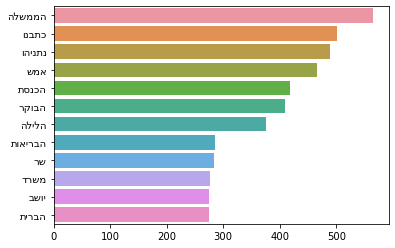

In [15]:
morning_df = df.loc[df['hour'] == 8]
morning_text = morning_df["paragraph"]
plot_top_non_stopwords_barchart(morning_text, stop)

# Top N-grams Barchart


In [16]:
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    #stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=invert_words(x))

### Bigrams

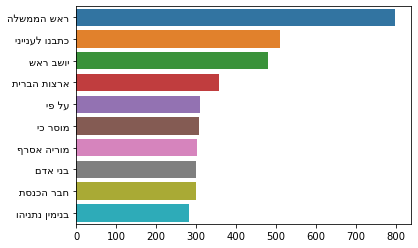

In [17]:
plot_top_ngrams_barchart(paragraph_text,2)

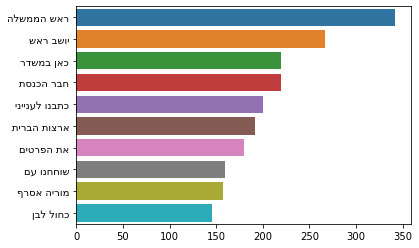

In [18]:
plot_top_ngrams_barchart(morning_text,2)

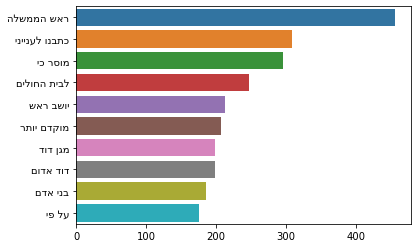

In [19]:
plot_top_ngrams_barchart(evening_text,2)

### Trigrams

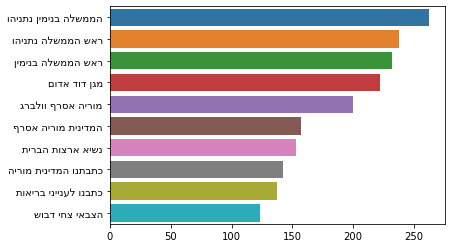

In [20]:
plot_top_ngrams_barchart(paragraph_text,3)

# LDA topics

In [21]:
import numpy as np
import nltk
nltk.download('punkt')
#from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models


def get_lda_objects(text, stop):
    #nltk.download('stopwords')    
    #top=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 20, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sapir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\sapir\miniconda3\envs\hebNLP_project\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [22]:
lda_model, bow_corpus, dic = get_lda_objects(paragraph_text, stop)
lda_model.show_topics()

C:\Users\sapir\miniconda3\envs\hebNLP_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(13,
  '0.005*"כתבנו" + 0.005*"הבריאות" + 0.004*"כתבתנו" + 0.004*"לענייני" + 0.003*"המדינה" + 0.003*"עשרה" + 0.003*"במשרד" + 0.003*"הבוקר" + 0.003*"אתמול" + 0.003*"הממשלה"'),
 (3,
  '0.004*"כתבנו" + 0.003*"הרווחה" + 0.003*"המדינה" + 0.003*"נמסר" + 0.003*"משרד" + 0.003*"הבוקר" + 0.003*"צהל" + 0.003*"הביטחון" + 0.002*"עשרים" + 0.002*"יגור"'),
 (15,
  '0.006*"הכנסת" + 0.004*"כתבנו" + 0.004*"בעקבות" + 0.003*"לפיד" + 0.003*"הבריאות" + 0.003*"אמש" + 0.003*"לראשונה" + 0.003*"לענייני" + 0.003*"ועדת" + 0.003*"צהל"'),
 (19,
  '0.006*"הממשלה" + 0.006*"הקורונה" + 0.005*"הסגר" + 0.005*"סגר" + 0.004*"כתבתנו" + 0.004*"הבחירות" + 0.004*"אסרף" + 0.004*"מוריה" + 0.003*"הפרופסור" + 0.003*"וולברג"'),
 (7,
  '0.008*"כתבנו" + 0.007*"הממשלה" + 0.005*"לענייני" + 0.004*"הבוקר" + 0.004*"נתניהו" + 0.003*"מאות" + 0.003*"אבו" + 0.003*"הבריאות" + 0.003*"הפלסטינית" + 0.003*"אמש"'),
 (12,
  '0.018*"הבריאות" + 0.016*"מאות" + 0.013*"משרד" + 0.011*"החולים" + 0.009*"אלף" + 0.008*"בישראל" + 0.007*"אובחנו" + 0.006*"חולים"

In [23]:
plot_lda_vis(lda_model, bow_corpus, dic)

C:\Users\sapir\miniconda3\envs\hebNLP_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.034618  0.090724       1        1  10.208977
18    -0.142706  0.031493       2        1   9.426674
5      0.249154  0.181732       3        1   8.729525
12    -0.094559  0.073826       4        1   7.052039
10    -0.032089  0.033350       5        1   6.732924
7     -0.008961  0.013853       6        1   5.334304
8     -0.029698  0.013163       7        1   5.316164
17     0.012529 -0.106030       8        1   4.991032
0     -0.004148  0.046260       9        1   4.493385
13    -0.037627  0.025693      10        1   4.297163
19    -0.102925  0.015416      11        1   3.967949
14     0.006415 -0.062074      12        1   3.941025
16    -0.013688  0.019021      13        1   3.910862
2     -0.063584 -0.015173      14        1   3.766697
4      0.125543 -0.027373      15        1   3.560351
6     -0.015448 -0.080705      16        1   3.290085
3      0.064810 -0.031614      17        1   3.123283
15    -0.016184 -0.006837      18        1   2.830188
9      0.033991 -0.015820      19        1   2.623898
11     0.103793 -0.198906      20        1   2.403474, topic_info=          Term        Freq       Total Category  logprob  loglift
210      טראמפ  317.000000  317.000000  Default  30.0000  30.0000
897      הברית  413.000000  413.000000  Default  29.0000  29.0000
1342     הכנסת  573.000000  573.000000  Default  28.0000  28.0000
479     החולים  583.000000  583.000000  Default  27.0000  27.0000
886      ארצות  290.000000  290.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
882     שלושים    9.098851  198.289002  Topic20  -6.2669   0.6467
3505    אחוזים    8.729889  180.932802  Topic20  -6.3083   0.6969
337      לשעבר    8.449807  173.639306  Topic20  -6.3409   0.7054
25848  לקורונה    8.208079   98.399136  Topic20  -6.3699   1.2443
1043     הבוקר    8.357670  508.166088  Topic20  -6.3519  -0.3794

[1582 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
31104      5  0.925501       110
34490      7  0.919606  Anabtawi
32058     18  0.869074       EMA
5634       6  0.618540       אבו
5634       7  0.070690       אבו
...      ...       ...       ...
3729      17  0.100733      תקפו
8223       5  0.142263     תרגיל
8223      17  0.853576     תרגיל
5380       8  0.909778      תרזה
21194     12  0.846720      תשרי

[5305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 6, 13, 11, 8, 9, 18, 1, 14, 20, 15, 17, 3, 5, 7, 4, 16, 10, 12])